In [11]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from scipy import stats
from matplotlib.colors import TwoSlopeNorm
import regionmask
import pandas as pd
from matplotlib import colors
from cartopy.util import add_cyclic_point

In [9]:
def linear_trend(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return slope, p_value

def symmetric_vlim(data):
    vmax = np.nanpercentile(np.abs(data), 98)
    return (-vmax, vmax)
def get_lat_lon(ds_like):
    """
    Identify latitude and longitude coordinate names in a DataArray or Dataset.
    Returns (lat_name, lon_name).
    """
    lon_candidates = ["lon", "longitude", "LONGITUDE", "x"]
    lat_candidates = ["lat", "latitude", "LATITUDE", "y"]

    lon_name = next((name for name in lon_candidates if name in ds_like.coords), None)
    lat_name = next((name for name in lat_candidates if name in ds_like.coords), None)

    if lon_name is None:
        raise ValueError("Longitude coordinate not found.")
    if lat_name is None:
        raise ValueError("Latitude coordinate not found.")

    return lat_name, lon_name
def to_cyclic(data2d, lon1d):
    """Add a cyclic point to avoid a seam at the dateline."""
    data_cyc, lon_cyc = add_cyclic_point(np.asarray(data2d), coord=np.asarray(lon1d))
    return data_cyc, lon_cyc

def plot_panel(ax, data, pvals, title, units="",
               vlim=None, cmap="RdBu_r",
               coastline_lw=0.5, hatch="...", hatch_non_sig=True,
               lat_name="lat", lon_name="lon", lat=None, lon=None, pc=None):
    """
    Plot a global map with trends and significance hatching.

    Parameters
    ----------
    ax : cartopy GeoAxes
        Axis to plot on.
    data : xarray.DataArray
        2D field (lat, lon).
    pvals : xarray.DataArray or None
        Matching p-values; if not None and hatch_non_sig=True,
        hatch regions where p >= 0.10.
    title : str
        Panel title.
    units : str
        Label for colorbar.
    vlim : tuple (vmin, vmax) or None
        Value range. If None, computed robustly from data.
    cmap : str
        Colormap.
    coastline_lw : float
        Coastline linewidth.
    hatch : str
        Hatch style for non-significant regions.
    hatch_non_sig : bool
        Whether to hatch p >= 0.10.
    lat_name, lon_name : str
        Names of latitude and longitude dims.
    lat, lon : xarray.DataArray
        Latitude and longitude coords.
    pc : cartopy.crs projection
        Typically ccrs.PlateCarree().
    """

    dat = np.asarray(data)

    # If no vlim passed, compute robust symmetric one
    if vlim is None:
        vmax = np.nanpercentile(np.abs(dat), 98)
        vlim = (-vmax, vmax)

    norm = TwoSlopeNorm(vcenter=0.0, vmin=vlim[0], vmax=vlim[1])

    # Wrap around to avoid seam
    Z, lon_c = to_cyclic(data.transpose(lat_name, lon_name), lon)

    im = ax.pcolormesh(lon_c, lat, Z,
                       cmap=cmap, norm=norm,
                       transform=pc, shading="nearest")

    # Optional hatching for non-significant areas
    if (pvals is not None) and hatch_non_sig:
        P, _ = to_cyclic(pvals.transpose(lat_name, lon_name), lon)
        non_sig = np.where(P >= 0.10, 1.0, np.nan)
        ax.contourf(lon_c, lat, non_sig,
                    levels=[0.5, 1.5], hatches=[hatch],
                    colors="none", transform=pc)

    # Coastline, grid, title
    ax.add_feature(cfeature.COASTLINE.with_scale("110m"), linewidth=coastline_lw)
    ax.set_global()
    ax.set_title(title, fontsize=11, pad=6)

    # Small per-panel horizontal colorbar
    cb = plt.colorbar(im, ax=ax, orientation="horizontal", fraction=0.045, pad=0.06)
    cb.ax.set_xlabel(units, fontsize=9)
    cb.ax.tick_params(labelsize=8)

    return im


In [3]:
ds_pr = xr.open_dataset('../../Data/Observations/ERA5/ERA5_mtpr_mer_1m_1979_2024.nc').mtpr.sel(valid_time=slice('1979','2024'))*86400
ds_t2m = xr.open_dataset('../../Data/Observations/ERA5/ERA5_msl_t2m_skt_sst_1m_1979_2024.nc').t2m.sel(valid_time=slice('1979','2024'))-273.15
ds_sst = xr.open_dataset('../../Data/Observations/ERA5/ERA5_msl_t2m_skt_sst_1m_1979_2024.nc').sst.sel(valid_time=slice('1979','2024'))-273.15
ds_vp = xr.open_dataset('../../Data/Observations/ERA5/era5_velo_pot_200hpa_1yr_1979_2024.nc')
ds1 = xr.open_dataset('../../Data/Observations/ERA5/ERA5_q_u_v_200_850hpa_1m_1979_2022.nc').sel(time=slice('1979','2024'))
ds2 = xr.open_dataset('../../Data/Observations/ERA5/ERA5_q_u_v_200_850hpa_1m_2022_2024.nc').sel(valid_time=slice('1979','2024'))


In [4]:
ds2 = ds2.rename({'valid_time': 'time', 'pressure_level': 'level'})

# Drop expver from ds2 if present
if 'expver' in ds2.coords:
    ds2 = ds2.drop_vars('expver')

# Drop expver from ds1 if present (just to be safe)
if 'expver' in ds1.coords:
    ds1 = ds1.drop_vars('expver')

In [5]:
u1=ds1.u.sel(time=slice('1979','2022')).sel(level=850)
v1=ds1.v.sel(time=slice('1979','2022')).sel(level=850)

u2=ds2.u.sel(time=slice('2022','2024')).sel(level=850)
v2=ds2.v.sel(time=slice('2022','2024')).sel(level=850)

u1_yr = u1.groupby('time.year').mean()
v1_yr = v1.groupby('time.year').mean()

u2_yr = u2.groupby('time.year').mean()
v2_yr = v2.groupby('time.year').mean()

u_yr = xr.concat([u1_yr, u2_yr], dim='year')
v_yr = xr.concat([v1_yr, v2_yr], dim='year')

In [6]:
ws_yr = np.sqrt((u_yr*u_yr)+(v_yr*v_yr))

In [7]:
pr_yr = ds_pr.groupby('valid_time.year').mean()
t2m_yr = ds_t2m.groupby('valid_time.year').mean()
sst_yr = ds_sst.groupby('valid_time.year').mean()
vp_yr = ds_vp.velocity_potential

In [8]:
trend_slope_pr , trend_pvalue_pr  = xr.apply_ufunc(linear_trend,pr_yr['year'], pr_yr,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])

trend_slope_t2m , trend_pvalue_t2m  = xr.apply_ufunc(linear_trend,t2m_yr['year'], t2m_yr,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])

trend_slope_sst , trend_pvalue_sst  = xr.apply_ufunc(linear_trend,sst_yr['year'], sst_yr,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])

trend_slope_vp , trend_pvalue_vp  = xr.apply_ufunc(linear_trend,vp_yr['year'], vp_yr,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])

trend_slope_u , trend_pvalue_u  = xr.apply_ufunc(linear_trend,u_yr['year'], u_yr,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])

trend_slope_v , trend_pvalue_v  = xr.apply_ufunc(linear_trend,v_yr['year'], v_yr,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])

trend_slope_ws , trend_pvalue_ws  = xr.apply_ufunc(linear_trend,ws_yr['year'], ws_yr,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])

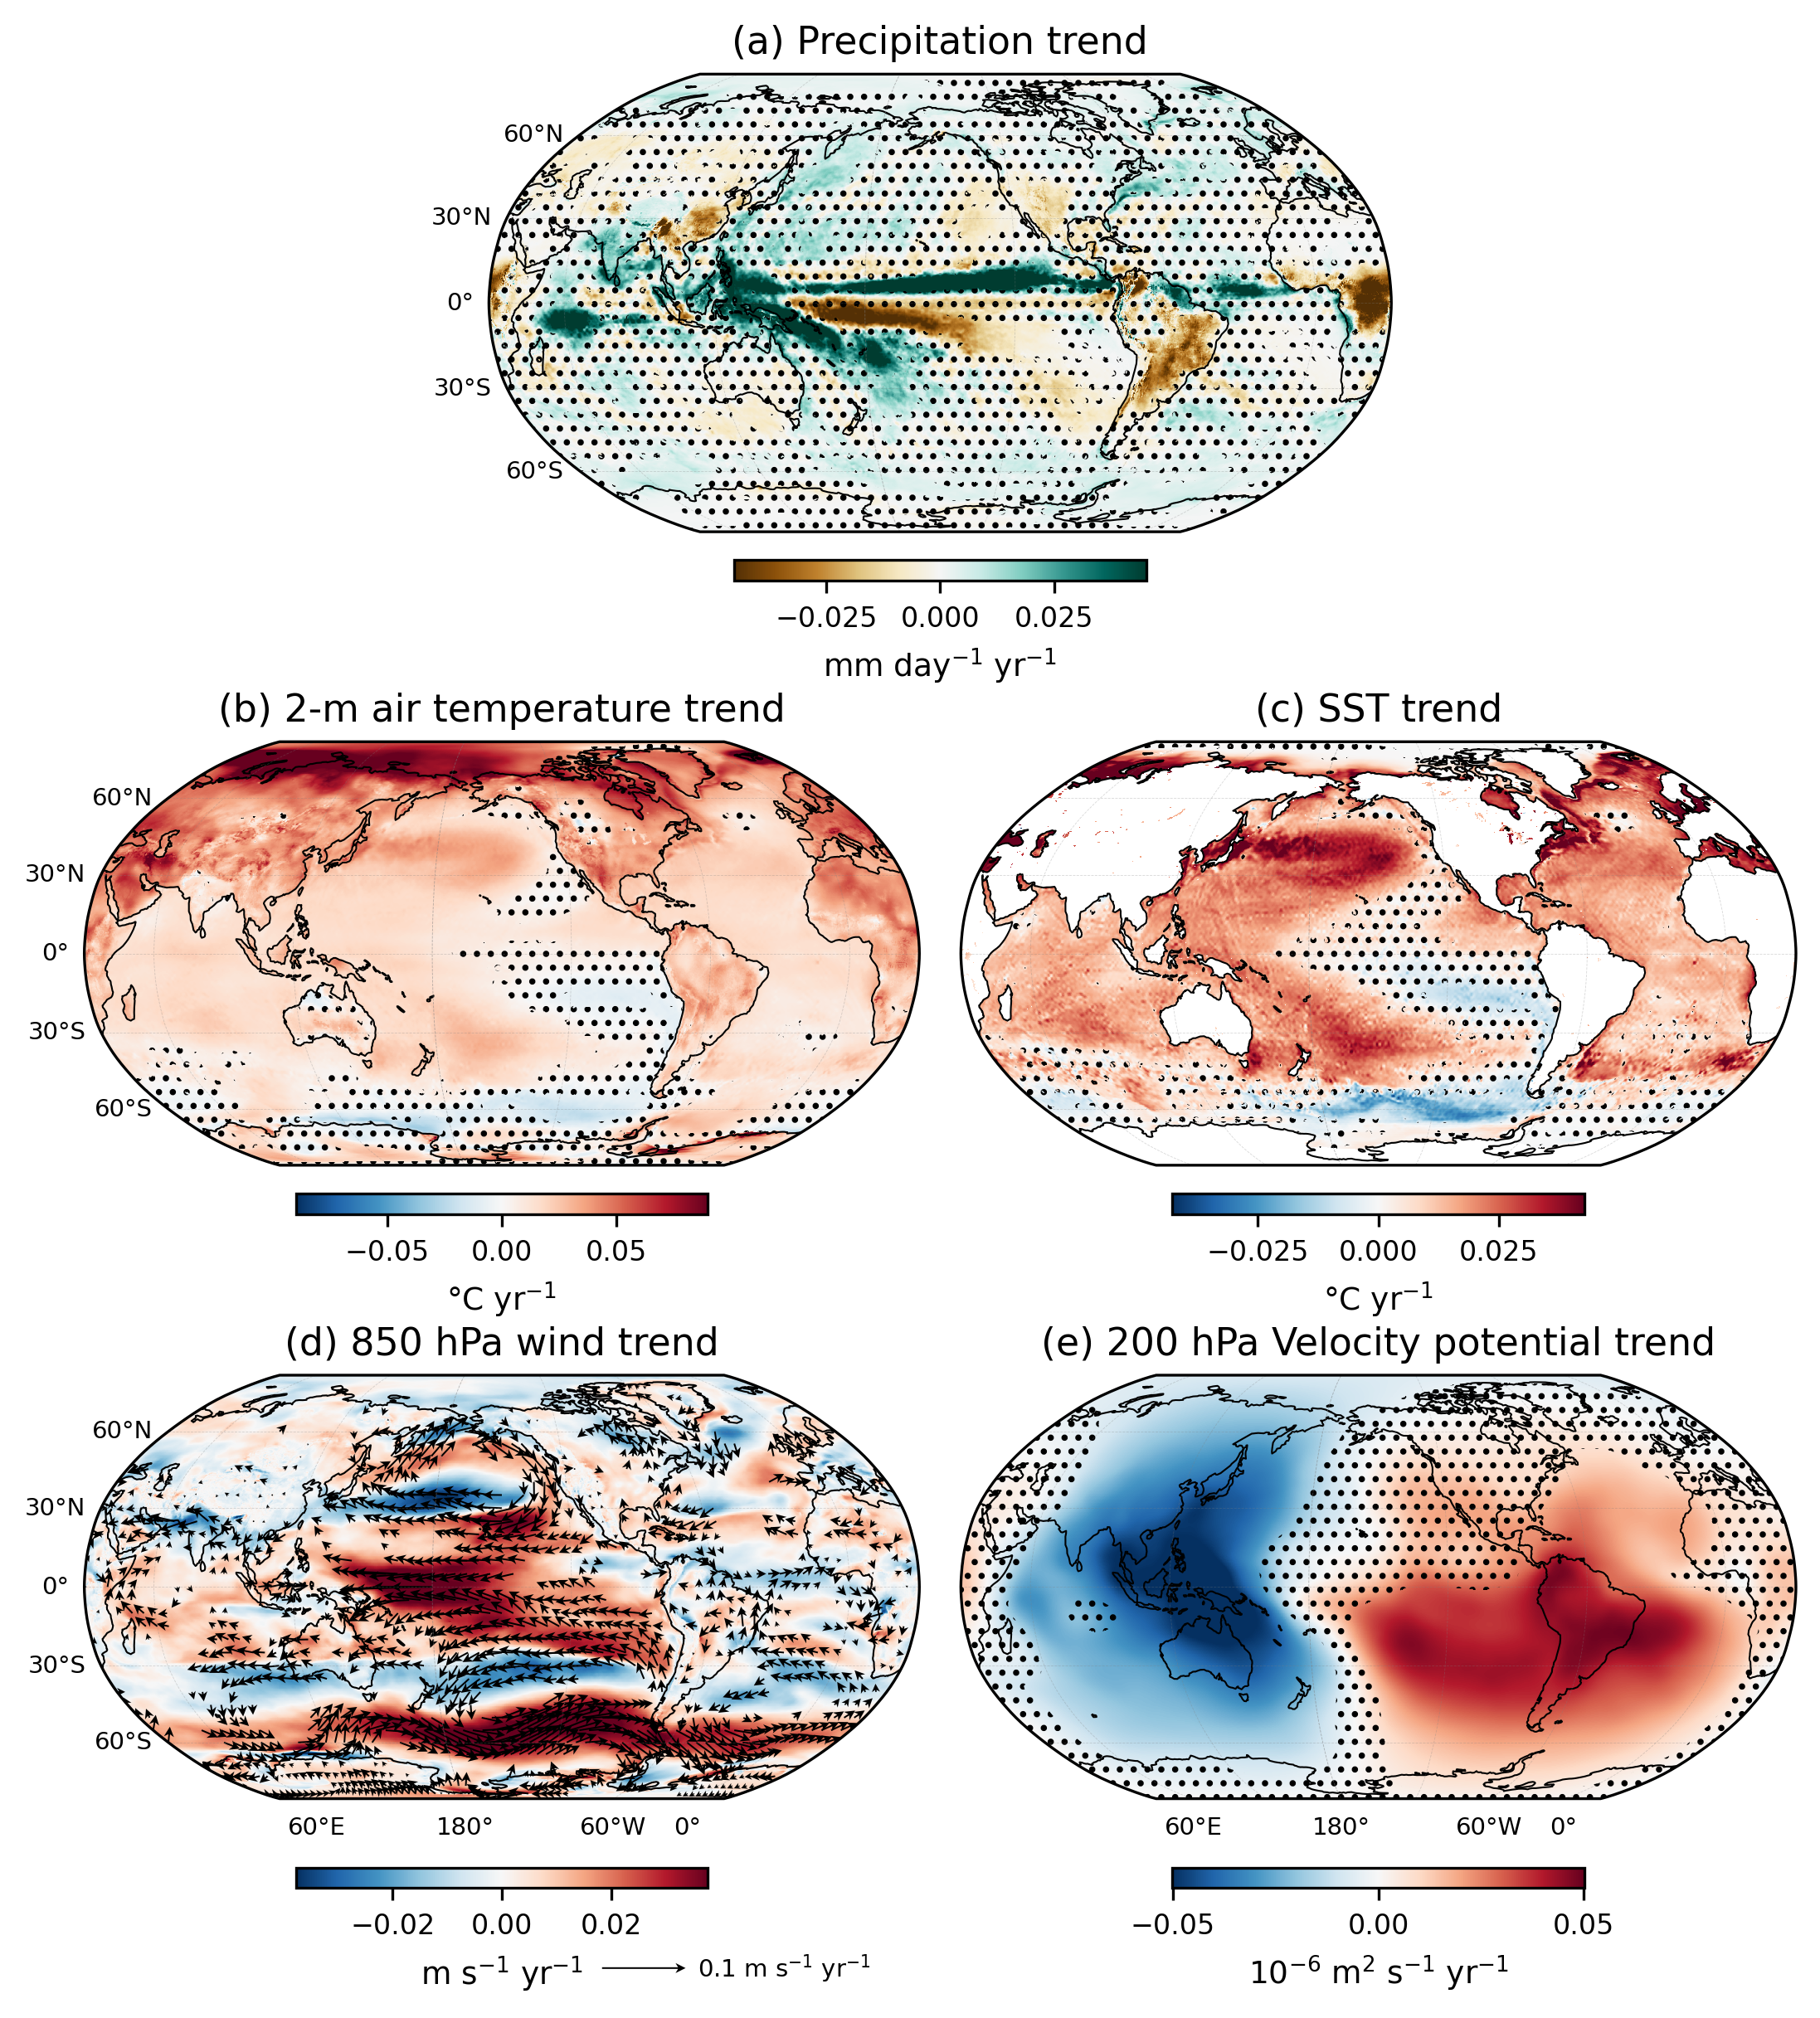

In [12]:

# --- vlims (add VP) ---
vp_trend_scaled = trend_slope_vp * 1e-6  # scale to 1e-6 units for display
vlims = {
    "pr":  symmetric_vlim(trend_slope_pr),
    "t2m": symmetric_vlim(trend_slope_t2m),
    "sst": symmetric_vlim(trend_slope_sst),
    "ws":  symmetric_vlim(trend_slope_ws),
    "vp":  symmetric_vlim(vp_trend_scaled),
}

# --- coords per panel (already in your code) ---
lat_name,  lon_name  = get_lat_lon(trend_slope_pr)
lat,  lon  = trend_slope_pr[lat_name],  trend_slope_pr[lon_name]

pc  = ccrs.PlateCarree()
rob = ccrs.Robinson(central_longitude=210)
# -------------------------------------------------
# Figure layout (big top row for precipitation trend)
# -------------------------------------------------
plt.rcParams.update({
    "font.size": 9,
    "font.family": "DejaVu Sans",
    "figure.dpi": 300,
})

fig = plt.figure(figsize=(7.2, 8), constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[1.0, 1.0, 1.0])


ax_a = fig.add_subplot(gs[0, 0:2], projection=rob)   # BIG width, same height
ax_b = fig.add_subplot(gs[1, 0], projection=rob)
ax_c = fig.add_subplot(gs[1, 1], projection=rob)
ax_d = fig.add_subplot(gs[2, 0], projection=rob)
ax_e = fig.add_subplot(gs[2, 1], projection=rob)
axes = [ax_a, ax_b, ax_c, ax_d, ax_e]

# -------------------------------------------------
# Panel A: BIG precipitation trend (focus)
# -------------------------------------------------
plot_panel(
    ax_a,
    trend_slope_pr,
    trend_pvalue_pr,
    title="(a) Precipitation trend",
    units="mm day$^{-1}$ yr$^{-1}$",
    cmap="BrBG",
    hatch_non_sig=True,
    lat_name=lat_name, lon_name=lon_name, lat=lat, lon=lon, pc=pc
)

# -------------------------------------------------
# Panel B: 2-m air temperature trend
# -------------------------------------------------
plot_panel(
    ax_b,
    trend_slope_t2m,
    trend_pvalue_t2m,
    title="(b) 2-m air temperature trend",
    units="°C yr$^{-1}$",
    cmap="RdBu_r",
    hatch_non_sig=True,
    lat_name=lat_name, lon_name=lon_name, lat=lat, lon=lon, pc=pc
)

# -------------------------------------------------
# Panel C: SST trend
# -------------------------------------------------
plot_panel(
    ax_c,
    trend_slope_sst,
    trend_pvalue_sst,
    title="(c) SST trend",
    units="°C yr$^{-1}$",
    cmap="RdBu_r",
    hatch_non_sig=True,
    lat_name=lat_name, lon_name=lon_name, lat=lat, lon=lon, pc=pc
)

# -------------------------------------------------
# Panel D: Wind speed trend + quivers
# -------------------------------------------------
plot_panel(
    ax_d,
    trend_slope_ws,
    trend_pvalue_ws,
    title="(d) 850 hPa wind trend",
    units="m s$^{-1}$ yr$^{-1}$",
    cmap="RdBu_r",
    hatch_non_sig=False,
    lat_name=lat_name, lon_name=lon_name, lat=lat, lon=lon, pc=pc
)

# Quiver overlays for wind (same as your original logic)
step_lon = 20
step_lat = 20
u_tr = trend_slope_u.transpose(lat_name, lon_name)
v_tr = trend_slope_v.transpose(lat_name, lon_name)
pu = trend_pvalue_u.transpose(lat_name, lon_name)
pv = trend_pvalue_v.transpose(lat_name, lon_name)
sig_mask = (pu < 0.10) | (pv < 0.10)
u_sig = xr.where(sig_mask, u_tr, np.nan)
v_sig = xr.where(sig_mask, v_tr, np.nan)
u_sub = u_sig.isel({lat_name: slice(0, None, step_lat), lon_name: slice(0, None, step_lon)})
v_sub = v_sig.isel({lat_name: slice(0, None, step_lat), lon_name: slice(0, None, step_lon)})
lat_sub = lat.isel({lat_name: slice(0, None, step_lat)})
lon_sub = lon.isel({lon_name: slice(0, None, step_lon)})

Q_d = ax_d.quiver(
    lon_sub.values, lat_sub.values, u_sub.values, v_sub.values,
    transform=pc, scale=1, width=0.002, headwidth=6, headlength=6
)
import matplotlib.font_manager as fm
ax_d.quiverkey(
    Q_d, X=0.72, Y=-0.4, U=0.1,
    label="0.1 m s$^{-1}$ yr$^{-1}$",
    labelpos="E", labelsep=0.05,
    fontproperties=fm.FontProperties(size=7)
)
vp_trend_1 = trend_slope_vp * 1e-6
pval_1 = trend_pvalue_vp
# -------------------------------------------------
# Panel E: Velocity potential trend
# -------------------------------------------------
plot_panel(
    ax_e,
    vp_trend_1,
    pval_1,
    title="(e) 200 hPa Velocity potential trend",
    units=r"$10^{-6}$ m$^{2}$ s$^{-1}$ yr$^{-1}$",
    cmap="RdBu_r",
    hatch_non_sig=True,
    lat_name=lat_name, lon_name=lon_name, lat=lat, lon=lon, pc=pc
)

gridliners = {}
for ax in axes:
    gl = ax.gridlines(
        crs=pc, draw_labels=True,
        linewidth=0.2,        # thinner
        color="0.5",
        alpha=0.3,            # lighter
        linestyle="--"
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 7}
    gl.ylabel_style = {"size": 7}
    gridliners[ax] = gl

# Left labels only on left column + top wide panel
gridliners[ax_a].left_labels = True
gridliners[ax_b].left_labels = True
gridliners[ax_d].left_labels = True
gridliners[ax_c].left_labels = False
gridliners[ax_e].left_labels = False

# Bottom labels only on bottom row (wind + vp)
gridliners[ax_d].bottom_labels = True
gridliners[ax_e].bottom_labels = True
gridliners[ax_a].bottom_labels = False
gridliners[ax_b].bottom_labels = False
gridliners[ax_c].bottom_labels = False

plt.savefig("./Figures/Figure_1.png", dpi=600, bbox_inches="tight")
plt.show()


In [13]:
vlims

{'pr': (-0.0451588775800622, 0.0451588775800622),
 't2m': (-0.0899739625467917, 0.0899739625467917),
 'sst': (-0.04271991922781953, 0.04271991922781953),
 'ws': (-0.03766090817029484, 0.03766090817029484),
 'vp': (-0.05010399277304964, 0.05010399277304964)}